# Movies Recommendation System Project

## ML Course Group project
### Members:
1. Jai Shanker - BSCS2020-43
3. Soban - BSCS2020-05




### Creating a movies Recommender System using Content-based Filtering

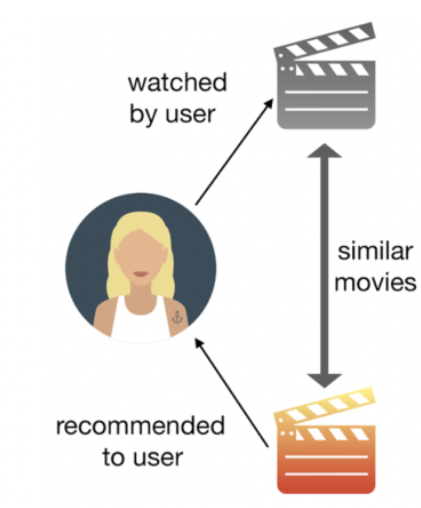

# Analysis and Modelling:
  
   #### 1. Exploratory Data Analysis
    1.1 Exploring the Users Dataset
    1.2 Exploring the Movies and Ratings Datasets
  
   #### 2. First Iteration: Building Recommender with CBF (Content Based Filtering) model
    2.1 Splitting the Dataset
    2.2 Baseline Model
    2.3 Content-based Filtering
    
    
   #### 3. Final Test and Evaluation
   
   

In [68]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
import time
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import minmax_scale

# Setting plot style
plt.style.use('ggplot')

In [69]:
# Reading the data from the CSV files
user_data = pd.read_csv("Movies_Dataset/User.csv")
rating_data = pd.read_csv("Movies_Dataset/Ratting.csv")
film_data = pd.read_csv("Movies_Dataset/film.csv")

In [70]:
user_data

,UserID,Gender,Age,Job,Postcode
0,0,F,45,6,92103
1,1,M,50,16,55405-2546
2,2,M,18,20,44089
3,3,M,35,1,33304
4,4,M,35,6,48105
...,...,...,...,...,...
6035,6036,M,45,0,61821
6036,6037,F,1,0,756
6037,6038,M,25,16,33301
6038,6039,M,35,14,92075


In [71]:
user_data.describe()

,UserID,Age,Job
count,6040.000000,6040.000000,6040.000000
mean,3020.465894,29.894868,8.200828
std,1743.799216,12.484335,10.933051
min,0.000000,1.000000,0.000000
25%,1510.750000,25.000000,1.000000
50%,3020.500000,25.000000,6.000000
75%,4530.250000,35.000000,13.000000
max,6040.000000,56.000000,98.000000


In [72]:
print(user_data.isnull().sum())

UserID      0
Gender      0
Age         0
Job         0
Postcode    0
dtype: int64


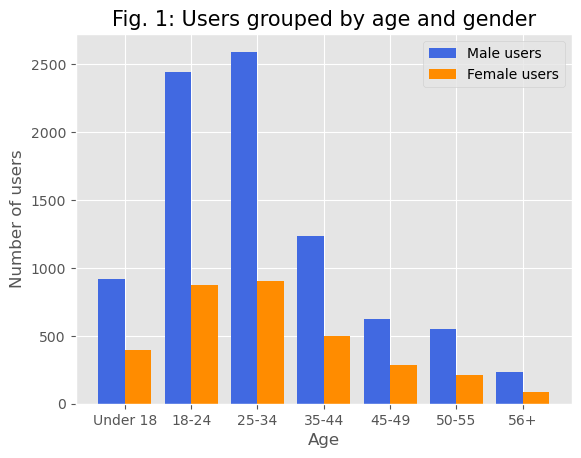

In [73]:
# Grouping User data into Male and Female age groups
gender_age = user_data[["Gender", "Age"]]
female_user_ages = gender_age.loc[gender_age['Gender'] == 'F'].sort_values('Age')
male_user_ages = gender_age.loc[gender_age['Gender'] == 'M'].sort_values('Age')


def get_group_count(start_age, end_age, user_data):
    return len(user_data.loc[(user_data['Age'] >= start_age) & (user_data['Age'] <= end_age)])

G1_male = get_group_count(0, 18, male_user_ages)
G2_male = get_group_count(17, 25, male_user_ages)
G3_male = get_group_count(24, 35, male_user_ages)
G4_male = get_group_count(34, 45, male_user_ages)
G5_male = get_group_count(44, 50, male_user_ages)
G6_male = get_group_count(49, 56, male_user_ages)
G7_male = get_group_count(55, 120, male_user_ages)

G1_female = get_group_count(0, 18, female_user_ages)
G2_female = get_group_count(17, 25, female_user_ages)
G3_female = get_group_count(24, 35, female_user_ages)
G4_female = get_group_count(34, 45, female_user_ages)
G5_female = get_group_count(44, 50, female_user_ages)
G6_female = get_group_count(49, 56, female_user_ages)
G7_female = get_group_count(55, 120, female_user_ages)

# Figure 1: Visualizing the userbase by plotting age and gender to a bar chart
labels = ['Under 18', '18-24', '25-34', '35-44', '45-49', '50-55', '56+']
men_grouped = [G1_male, G2_male, G3_male, G4_male, G5_male, G6_male, G7_male]
women_grouped = [G1_female, G2_female, G3_female, G4_female, G5_female, G6_female, G7_female]
x = np.arange(len(labels))  # the label locations
width = 0.40  # the width of the bars

fig1, ax1 = plt.subplots()
rects1 = ax1.bar(x - width/2, men_grouped, width, label='Male users', color='royalblue')
rects2 = ax1.bar(x + width/2, women_grouped, width, label='Female users', color='darkorange')

# Setting the labels for the bar chart
ax1.set_ylabel('Number of users', size=12)
ax1.set_xlabel('Age', size=12)
ax1.set_xticks(x)
ax1.set_xticklabels(labels)
ax1.set_title('Fig. 1: Users grouped by age and gender', size=15)
ax1.legend()

plt.show()


In [74]:
rating_data

,UserID,FilmID,Rating,Timestamp
0,0,1561,4,959441640
1,0,1540,3,959441640
2,0,88,3,959441640
3,0,620,4,959441640
4,0,3771,5,959442113
...,...,...,...,...
900112,6040,1153,4,976584194
900113,6040,3714,4,976584260
900114,6040,2834,5,976584260
900115,6040,48,5,976584300


In [75]:
rating_data.describe()

,UserID,FilmID,Rating,Timestamp
count,900117.000000,900117.000000,900117.000000,9.001170e+05
mean,2991.868675,1989.666242,3.581491,9.722407e+08
std,1736.208380,1126.359558,1.117162,1.214212e+07
min,0.000000,0.000000,1.000000,9.567039e+08
25%,1458.000000,1037.000000,3.000000,9.653030e+08
50%,2967.000000,1959.000000,4.000000,9.730170e+08
75%,4501.000000,2963.000000,4.000000,9.752206e+08
max,6040.000000,3952.000000,5.000000,1.046455e+09


In [76]:
print(rating_data.isnull().sum())

UserID       0
FilmID       0
Rating       0
Timestamp    0
dtype: int64


In [77]:
film_data

,FilmID,Title,Action,Adventure,Animated,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,Autumn in New York (2000),0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
1,1,"Vie est belle, La (Life is Rosey) (1987)",0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
2,2,Defying Gravity (1997),0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,3,Ruthless People (1986),0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,Portraits Chinois (1996),0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3878,3948,Cat People (1982),0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3879,3949,"Saltmen of Tibet, The (1997)",0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3880,3950,Bride of Re-Animator (1990),0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
3881,3951,True Lies (1994),1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0


In [78]:
film_data.describe()

,FilmID,Action,Adventure,Animated,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
count,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000
mean,1973.687098,0.129539,0.072882,0.027041,0.040948,0.309039,0.054339,0.032707,0.412825,0.017512,0.011074,0.088334,0.029359,0.027041,0.121040,0.071079,0.126706,0.036827,0.017512
std,1142.105375,0.335839,0.259976,0.162224,0.198195,0.462157,0.226715,0.177891,0.492405,0.131187,0.104662,0.283816,0.168832,0.162224,0.326216,0.256990,0.332686,0.188362,0.131187
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,985.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1973.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2963.500000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3952.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [79]:
print(film_data.isnull().sum())

FilmID         0
Title          0
Action         0
Adventure      0
Animated       0
Children's     0
Comedy         0
Crime          0
Documentary    0
Drama          0
Fantasy        0
Film-Noir      0
Horror         0
Musical        0
Mystery        0
Romance        0
Sci-Fi         0
Thriller       0
War            0
Western        0
dtype: int64


In [80]:
# Calculate the average rating across all users and movies
average_rating = rating_data['Rating'].mean()

print("Average Rating across all users and movies is:", average_rating)

Average Rating across all users and movies is: 3.581491072827199


My unconfirmed hypothesis for why this number is so high, is that most people watch movies that have been recommended to them, either by friends or by recommender systems. People also tend to do some research into which movie they want to watch, like watching a trailer, reading a review, etc.

In [81]:
# Merge rating data with film data to get genre information
genres = list(film_data)[2:]
merged_data = pd.merge(rating_data, film_data, on='FilmID')

cleaned = merged_data[['FilmID', 'UserID', 'Rating', 'Action', 'Adventure', 'Animated', "Children's", 'Comedy',
                  'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical',
                  'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western', 'Title']]


In [82]:
# Function for extracting the count of a specific rating for all genres
def get_rating_count(genre, rating):
    genre_list = cleaned[cleaned[genre] == 1]
    genre_rated_count = len(genre_list[genre_list['Rating'] == rating])
    return genre_rated_count

# Function for extracting the total number of ratings for all genres
def get_total_rating_count(genre):
    genre_list = cleaned[cleaned[genre] == 1]
    total_ratings = len(genre_list)
    return total_ratings

# Creating a list of ratings
ratings = [1, 2, 3, 4, 5]

# Creating empty lists to store the data
genre_list = []
rated_count_list = [[] for _ in range(len(ratings))]
total_rating_count_list = []

# Looping over genres and ratings to get the counts
for genre in genres:
    genre_list.append(genre)
    for i, rating in enumerate(ratings):
        rated_count_list[i].append(get_rating_count(genre, rating))
    total_rating_count_list.append(get_total_rating_count(genre))

# Creating a dictionary to construct the DataFrame
data = {
    'Genre': genre_list,
    'Rated 1': rated_count_list[0],
    'Rated 2': rated_count_list[1],
    'Rated 3': rated_count_list[2],
    'Rated 4': rated_count_list[3],
    'Rated 5': rated_count_list[4],
    'Total nr of ratings': total_rating_count_list
}

# Creating the DataFrame
genre_df = pd.DataFrame(data)

# Calculating the average rating
genre_df['Average rating'] = (
    genre_df['Rated 1'] +
    genre_df['Rated 2'] * 2 +
    genre_df['Rated 3'] * 3 +
    genre_df['Rated 4'] * 4 +
    genre_df['Rated 5'] * 5
) / genre_df['Total nr of ratings']

# Printing the resulting DataFrame
genre_df

,Genre,Rated 1,Rated 2,Rated 3,Rated 4,Rated 5,Total nr of ratings,Average rating
0,Action,14884,28359,63691,77911,46969,231814,3.490574
1,Adventure,7675,15038,34070,39809,24009,120601,3.476273
2,Animated,1886,3264,9871,14258,9719,38998,3.683625
3,Children's,3500,4776,10932,11917,6554,37679,3.351628
4,Comedy,19410,36985,87148,111126,66128,320797,3.522377
5,Crime,2879,6726,17580,25579,18800,71564,3.708387
6,Documentary,246,425,1293,2723,2405,7092,3.932882
7,Drama,10917,26252,76415,118548,86967,319099,3.765894
8,Fantasy,2152,4269,9405,10513,6291,32630,3.445051
9,Film-Noir,243,764,2877,6186,6358,16428,4.074507


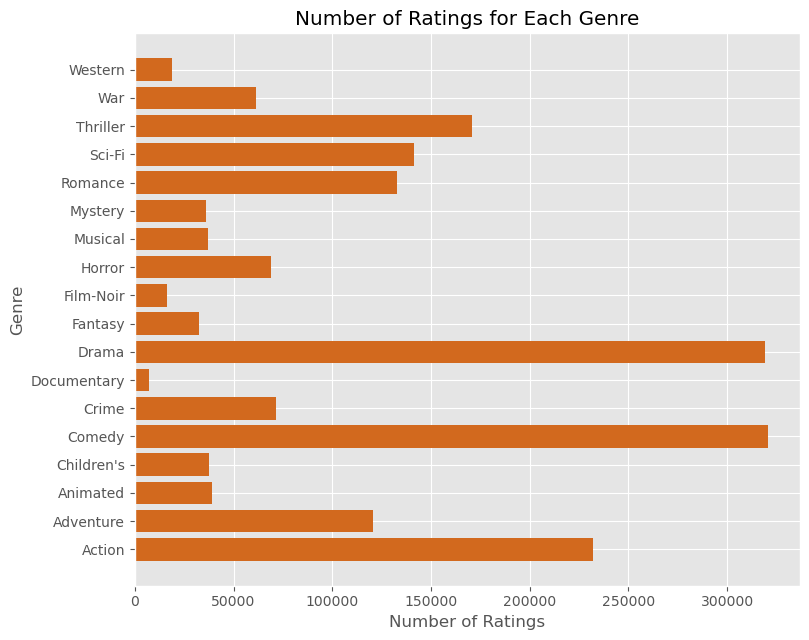

In [83]:
# Setting figure size
plt.figure(figsize=(15, 6.5))

# Plotting the number of ratings for each genre
plt.subplot(1, 2, 1)
plt.barh(genre_df['Genre'], genre_df['Total nr of ratings'], color='chocolate')
plt.xlabel('Number of Ratings')
plt.ylabel('Genre')
plt.title('Number of Ratings for Each Genre')

# Adjusting the spacing between subplots
plt.tight_layout()

# Displaying the plot
plt.show()

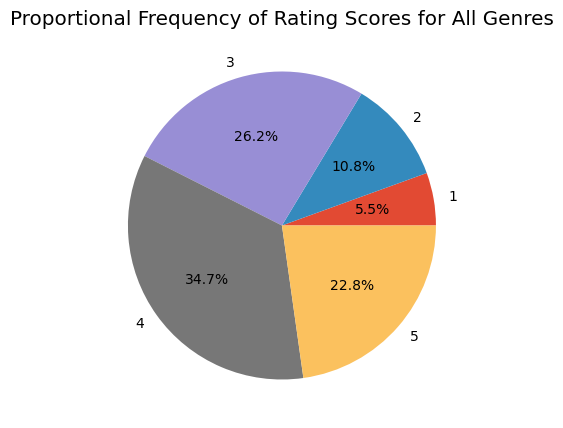

In [84]:
# Calculate the total count of ratings across all genres
total_ratings = genre_df[['Rated 1', 'Rated 2', 'Rated 3', 'Rated 4', 'Rated 5']].sum().values

# Calculate the proportion of each rating score
rating_proportions = total_ratings / total_ratings.sum()

# Create a pie chart
plt.figure(figsize=(5, 5))
plt.pie(rating_proportions, labels=ratings, autopct='%1.1f%%')
plt.title('Proportional Frequency of Rating Scores for All Genres')

# Display the pie chart
plt.show()

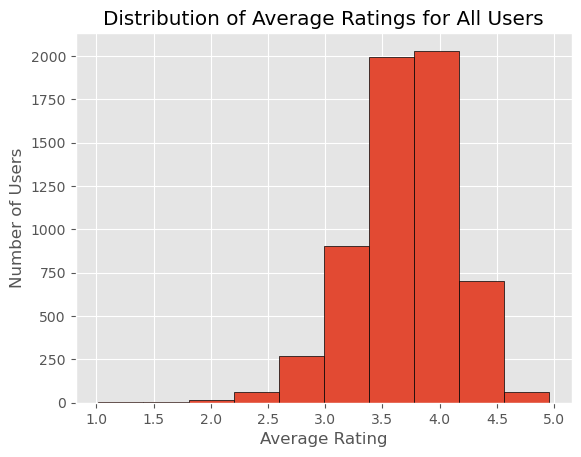

In [85]:
# Calculating the average ratings for each user
average_ratings = merged_data.groupby('UserID')['Rating'].mean()

# Plotting the distribution of average ratings
plt.hist(average_ratings, bins=10, edgecolor='black')
plt.xlabel('Average Rating')
plt.ylabel('Number of Users')
plt.title('Distribution of Average Ratings for All Users')
plt.show()

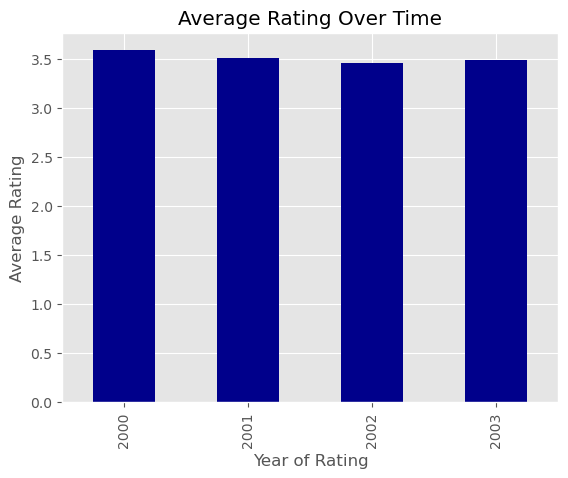

In [86]:

# Converting the Timestamp to a year
merged_data['Year'] = pd.to_datetime(merged_data['Timestamp'], unit='s').dt.year

# Calculating the average rating for each year
average_ratings_by_year = merged_data.groupby('Year')['Rating'].mean()

# Plotting the average rating over time
average_ratings_by_year.plot(kind='bar', color='darkblue')
plt.xlabel('Year of Rating')
plt.ylabel('Average Rating')
plt.title('Average Rating Over Time')
plt.show()

## 2) First Iteration: Building a Recommender System with CBF models


### 2.1) Splitting the Dataset

In [87]:
# Splitting the ratings dataset into the feature set (X) and target labels (y)
X = rating_data.drop(columns='Rating')
y = rating_data["Rating"].values  # The movie ratings are the target variables we want to predict

In [88]:
# Preparing train, validation and test datasets
X_train, X_val_and_test, y_train, y_val_and_test = train_test_split(X, y, test_size=0.3, random_state=101)
X_val, X_test, y_val, y_test = train_test_split(X_val_and_test, y_val_and_test, test_size=0.5, random_state=101)

# Creating a complete training dataset with X_train and y_train
train_df = X_train.copy()
train_df["Rating"] = y_train

train_df

,UserID,FilmID,Timestamp,Rating
708938,4341,1210,976573899,3
371257,1425,3192,970774826,4
845603,5565,2299,976239652,5
667558,3970,83,965770467,3
821518,5320,3843,976249576,4
...,...,...,...,...
661055,3915,1846,974698675,4
204614,32,884,974679433,4
476497,2357,101,975126955,4
214539,122,2098,974662091,4


## 2.2) The Baseline Model

In order to provide context for the evaluation of more advanced recommendation models, I will begin with constructing a very simple baseline model. I will use a popularity-based approach, where I calculate the average rating for each movie and simply predict that all users rate all movies after the movies' average rating. Even though this model provides no personalization, most users to in fact rate movies close to the average rating for the movies. I therefore expect that the RMSE for this model will prove to be somewhat challenging to beat.

In [105]:
# Creating a new dataframe with the average rating for each movie
baseline_y_pred = train_df.groupby('FilmID')['Rating'].mean().reset_index().rename(
                                                        columns={'Rating': 'Predicted rating'})

# Creating a dataframe for the validation data (y_true) to calculate RMSE of the baseline model
val_movies_df = pd.DataFrame({'FilmID': X_val["FilmID"], 'Actual rating': y_val})

# Merging the predicted ratings and actual ratings on the movie ID
baseline_y_pred_vs_y_true = pd.merge(baseline_y_pred, val_movies_df, on='FilmID')

baseline_y_pred_vs_y_true

,FilmID,Predicted rating,Actual rating
0,0,2.055556,1
1,0,2.055556,4
2,0,2.055556,3
3,0,2.055556,2
4,0,2.055556,2
...,...,...,...
134982,3952,2.353846,2
134983,3952,2.353846,1
134984,3952,2.353846,1
134985,3952,2.353846,3


In [106]:
# calculating RMSE for the baseline model
print("RMSE baseline model: ", sqrt(mean_squared_error(baseline_y_pred_vs_y_true["Predicted rating"], 
                                                       baseline_y_pred_vs_y_true["Actual rating"])))

accuracy = 1 - (0.981626106076701 / 5)
print(accuracy)

RMSE baseline model:  0.981626106076701
0.8036747787846599


# 2.3) Content Based Filtering

For the content-based filtering (CBF) models, I use the information about the users' movie preferences to predict recommendations. In particular, the CBF models use information about what each user has rated, what they rated, and the rated movie's genres to build an individual profile for each user. The model then predicts ratings for all of the other movies in the dataset the user has not seen.

I want to test a variety of different machine learning algorithms to establish which one is most beneficial for content-based recommendations on this dataset. Even though I suspect that the linear models will perform best, I will try out a few other types of machine learning algorithms as well for my own learning purposes.

The main advantage of CBF is that it takes individual user preferences into consideration. For movie recommendations, this is quite fitting, as we often have a few favourite movie genres, actors, directors, etc. that we enjoy more than others. Sadly, the movies dataset from MovieLens contains very few movie features, and content-based filtering models usually need a multitude of item features in order to accurately model user preferences. I will attempt to alleviate these problems with featue engineering in section 3.

Another disadvantage with CBF is that these models struggle with very sparse matrices. I will likely encounter this exact issue, as most users only rate a few movies. In contrast to collaborative filtering, CBF models also have a disadvantage in that they don't consider similarities between users, since they only focus on items (content) and individual users.

My hypothesis is that a content-based model which only uses the movie genre and user data will not be able to outperform the baseline model. To achieve this, CBF requires more features in the movies dataset. 

In [107]:
# ----------- PREPARING TRAINING DATA ----------- #
# Adding the movie features (genre, release year) to the training dataset
content_train_df = pd.merge(train_df, film_data, on='FilmID')
content_train_df.drop(columns=['Timestamp', 'FilmID', 'Title'], inplace=True)  # Remove useless features

content_train_df

,UserID,Rating,Action,Adventure,Animated,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,4341,3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,1242,3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,1056,5,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,4381,4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,1134,4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
630076,4551,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
630077,455,4,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
630078,2305,4,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
630079,317,3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [110]:
# Creating a list of lists with the target attribute (movie ratings), grouped by userID
y_grouped_by_user = content_train_df.groupby(["UserID"])
y_train_listed = []

for i, j in y_grouped_by_user:
    y_train_listed.append(j["Rating"].values)  # Extract target feature (ratings) from sorted data
    
# Target attributes for the first user
y_train_listed[0]

array([4, 1, 4, 3, 5, 3, 4, 3, 5, 2, 4, 4, 4, 3, 4, 5, 2, 2, 5, 4, 3, 2,
       4, 4, 3, 2, 3, 3, 5, 4, 5, 1, 5, 3, 3, 2, 4, 3, 3, 4, 5, 3, 2, 4,
       3, 5, 1, 1, 4, 4, 3, 2, 1, 4, 4, 3, 3, 3, 4, 4, 3, 3, 1, 4, 4, 5,
       4, 3, 3, 4, 2, 3, 2, 2, 4, 4, 3, 5, 4, 2, 4, 3, 3, 3, 4, 2, 4, 5,
       4, 3, 3, 4, 3, 2, 3, 2, 3, 4, 3, 4, 4, 4, 5, 3, 3, 4, 3, 3, 4, 3,
       3, 3, 3, 3, 3, 3, 4, 4, 3, 4, 4, 4, 3, 4, 3, 3, 5, 3, 4, 2, 3, 3,
       3, 3, 5, 2, 4, 3, 3, 4, 4, 3, 3, 5, 3, 2, 1, 3, 3, 3, 2, 3, 4, 3,
       2, 3, 3, 3, 4, 3, 4, 4, 2, 3, 3, 3, 2, 3, 4, 3], dtype=int64)

In [111]:
# Creating a list of dataframes with the feature set (movie info about genres and release year), grouped by userID
content_train_df.drop(columns='Rating', inplace=True)
x_grouped_by_user = content_train_df.groupby(["UserID"])
x_train_listed = []

for user_id, group in x_grouped_by_user:
    x_train_listed.append(group.drop(columns='UserID'))
    
# The feature set for the first user
x_train_listed[0]

,Action,Adventure,Animated,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
2824,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
9073,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1
14756,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
18316,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
22117,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
618870,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
618897,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
619528,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0
625089,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0


In [112]:
# Creating a new dataframe for the movies data
all_movies = film_data.drop(columns=['Title', 'FilmID'])
all_movies

,Action,Adventure,Animated,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3878,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3879,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3880,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
3881,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0


In [113]:
# ----------- PREPARING VALIDATION DATA ----------- #
# Creating a 2 dimensional matrix for the validation data in order to make it easier to calculate RMSE.

# Listing the user ID's in the same order as in the grouped dataframes
user_ids = []
for user_id, group in x_grouped_by_user:
    user_ids.append(user_id)
    
# Listing the movie IDs in the same order as in the movies dataset
movie_ids = film_data["FilmID"].values

# Creating the matrix. Axis 1: User IDs, Axis 2: Movie IDs. Elements: True ratings from validation data
df_val = X_val.copy()
df_val["Rating"] = y_val
validation_matrix = pd.DataFrame(index=user_ids, columns=movie_ids)  # Starting with an empty matrix
for array in df_val.to_records():  # Filling in the true ratings as elements
    user = array['UserID']
    movie = array['FilmID']
    true_rating = array['Rating']
    validation_matrix.loc[user][movie] = true_rating
    
validation_matrix

,0,1,2,3,4,5,6,7,8,9,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6038,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6039,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [114]:
# ----------- CREATING THE DIFFERENT CONTENT-BASED FILTERING MODELS ----------- #
# Assigning the different machine learning algorithms to be implemented in the models to a dictionary
ml_algorithms = {"Linear regression": LinearRegression(), "Lasso": Lasso(alpha=1.0, max_iter=10000), 
                 "KNN_7": KNeighborsRegressor(n_neighbors=7),
                 "RFR": RandomForestRegressor(n_estimators=1000, n_jobs=3, max_features="auto", random_state=0),
                 "SVR": SVR(C=1.0)}

# Saving lists that I later use to construct a dataframe containing the performances of the models
CBF_models_listed = []
RMSE_CBF_listed = []

# For every machine learning algorithm in the dictionary:
for name, ml_alg in ml_algorithms.items():
    # Create an empty list for predictions
    CBF_predictions = []

    # For each user in the training dataset:
    for i, x in enumerate(x_train_listed):
        # Fit a machine learning model
        ml_alg.fit(x_train_listed[i], y_train_listed[i])
        # Predict all the ratings for this user for all movies
        prediction = ml_alg.predict(all_movies)
        prediction = np.clip(prediction, 1, 5)  # Predictions must be minimum 1, maximum 5
        # Append all the predictions to the predictions list
        CBF_predictions.append(prediction)

    # Create a dataframe with the predictions
    df_predict = pd.DataFrame(CBF_predictions, index=user_ids, columns=movie_ids)

    # Create a dataframe with only the predictions for the movies-user combinations that appear in the validation set
    num_actual = validation_matrix.to_numpy().flatten()[validation_matrix.notna().to_numpy().flatten()]
    num_predict = df_predict.to_numpy().flatten()[validation_matrix.notna().to_numpy().flatten()]

    # Calculate the RMSE for the content-based filtering model and add the result to the lists
    RMSE_CBF_listed.append(sqrt(mean_squared_error(num_predict, num_actual)))
    CBF_models_listed.append(name)


# Printing the results
RMSE_CBF_df = pd.DataFrame({"Model": CBF_models_listed, "RMSE": RMSE_CBF_listed})
print("RMSE of different content-based filtering models without the year of release feature:")
RMSE_CBF_df

C:\Users\dell\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


RMSE of different content-based filtering models without the year of release feature:


,Model,RMSE
0,Linear regression,1.071366
1,Lasso,1.037082
2,KNN_7,1.058414
3,RFR,1.079411
4,SVR,1.054499


As expected, the linear models performed better than the KNN classifier, though none of them outperformed the baseline model. Lasso had a sinificantly lower RMSE than the rest, so I will therefore use Lasso for the recommender. It will however be interesting to see how feature engineering will affect both the classifier and the best linear models. I wonder whether the difference in RMSE between the different models will change or remain the same.

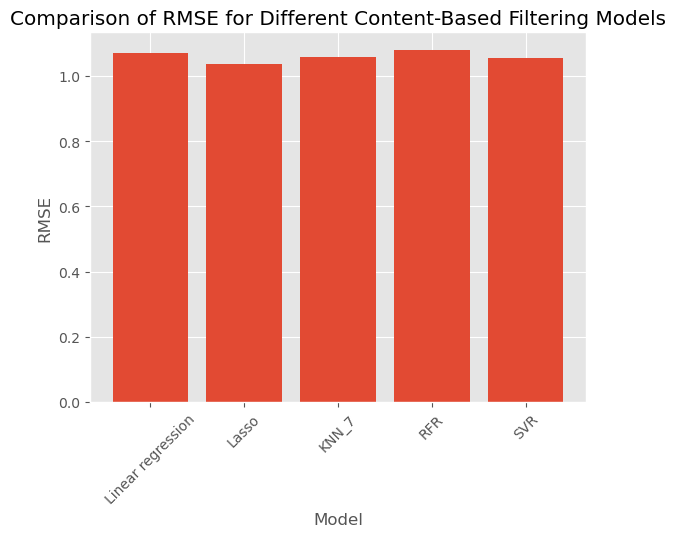

In [240]:
# Plotting the results
plt.bar(RMSE_CBF_df["Model"], RMSE_CBF_df["RMSE"])
plt.xlabel("Model")
plt.ylabel("RMSE")
plt.title("Comparison of RMSE for Different Content-Based Filtering Models")
plt.xticks(rotation=45)
plt.show()